# **Capstone Project: The Battle of The Neighborhoods**

## Introduction

 As an Italian American, I would like to embrace my heritage and open an Italian restaurant in one of the 5 boroughs of New York City. New York City is a large, ethnically diverse, and ever expanding city. As of 2018 New York City had a population of 8.623 million which makes up approximately 44% of New York State's population of 19.54 million.

Over the course of history, New York City has been a foremost point for entry among immigrants. These immigrants who have come to call New York City their home have brought with them varying aspects of their culture and heritage. One of the largest defining aspects of a culture is their cuisine. Judging by the sheer size of New York City and its immense diversity, one would expect there is no shortage of differing dining establishments based on the ethnicity of its cuisine. For this project, I will look at various neighborhoods within the boroughs of New York City and attempt to determine where is the optimal neighborhood to open an Italian restaurant. 

## Data

 In order to perform the tasks necessary for this project I will utilize the following data

- Italian Restaurants in the neighborhoods of each of the 5 boroughs
     - Data Source: Foursquare API
     - Description: The utilization of this API will give access to all dining establishments in a borough and by neighborhood. This can be further filtered to only show Italian Restaurants

- New York City Data
    - Data Source: https://cocl.us/new_york_dataset
    - Description: The utilization of this data set will allow exploration of the neighborhoods of the 5 boroughs of New York City. It contains necessary information regarding, the boroughs, the neighborhood, as well as the latitudes and longitudes

- Geo Spacial Data
    - Data Source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
    - Description: This data set will allow for a visualization of the borough boundaries.

## Approach to the Problem

- Collect and analyze data set for the New York City Data
- Use the Foursquare API to find all dining establishments in all the neighborhoods of the 5 boroughs
- Filter the data set to only show establishments that serve Italian cuisine
- Find neighborhoods who have only a small number of Italian restaurants
- Find neighborhoods who have poorly rated Italian restaurants
- Build a visualization of the boroughs and their Italian restaurants

In [2]:
#Import essential libraries
import pandas as pd
import numpy as np
import requests 
from bs4 import BeautifulSoup

!pip -q install geopy
from geopy.geocoders import Nominatim

import os

!pip -q install folium
import folium

import json
import datetime as dt

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

print("Libraries Installed Successfully!")

Libraries Installed Successfully!


In [3]:
CLIENT_ID = "2F1OV255HMPYFJ2UXS5B3D30WZCUAMRPCK3LS15JRCGMPHBQ"
CLIENT_SECRET = "2EWYOHUQHQVFPN2JQS5QKSGQF5OPYOJ0IGLUQE0QSTTI03RO"
VERSION = "20180605"

In [4]:
#Build functions to be utilized
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [5]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [6]:
ny_data.shape

(306, 4)

This tells us that there are 306 neighborhoods in New York

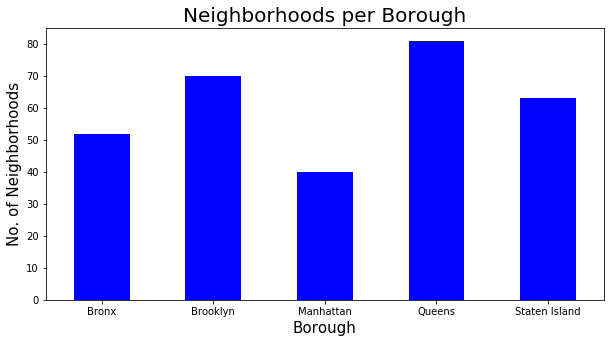

In [7]:
ny_data.groupby("Borough")["Neighborhood"].count().plot.bar(figsize=(10,5),color="blue")
plt.title("Neighborhoods per Borough", fontsize = 20)
plt.xlabel("Borough", fontsize = 15)
plt.ylabel("No. of Neighborhoods", fontsize = 15)
plt.xticks(rotation = "horizontal")
plt.show()

The graph above allows us to see the number of neighborhoods separated by the borough that they are in. Looking at the graph Queens has the most neighborhoods followed by Brooklyn, Staten Island, and the Bronx. Whereas Manhattan has the least number of neighborhoods. 

This only is a small step in answering the question of "where to open an Italian Restaurant". The next step is to take a look at the number of Italian Restaurants in each of the Boroughs. 

In [8]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_resturants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(ny_data),')','Italian Resturants in '+Neighborhood+', '+Borough+':'+str(len(italian_resturants)))
    print(row)
    for resturant_detail in italian_resturants.values.tolist():
        id, name , category=resturant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Italian Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Italian Resturants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Italian Resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Italian Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Italian Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Italian Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Italian Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Italian Resturants in Woodlawn, Bronx:1
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Italian Resturants in Norwood, Bronx:0
['Bronx', '

In [9]:
italian_rest_ny.to_csv("italian_rest_ny_tocsv1.csv")

In [10]:
italian_rest_ny = pd.read_csv("italian_rest_ny_tocsv1.csv")
italian_rest_ny.head()

,Unnamed: 0,Borough,Neighborhood,ID,Name
0,0,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn
1,1,Bronx,Pelham Parkway,4bf96ae65317a593d837017f,Enzo's
2,2,Bronx,Pelham Parkway,4b47f069f964a5208c4426e3,Pasta Pasta
3,3,Bronx,City Island,4514ed4df964a520e5391fe3,Artie's Steak and Seafood
4,4,Bronx,Country Club,4be35e62b02ec9b6b66b4fc0,Vibano's


In [11]:
italian_rest_ny.shape

(224, 5)

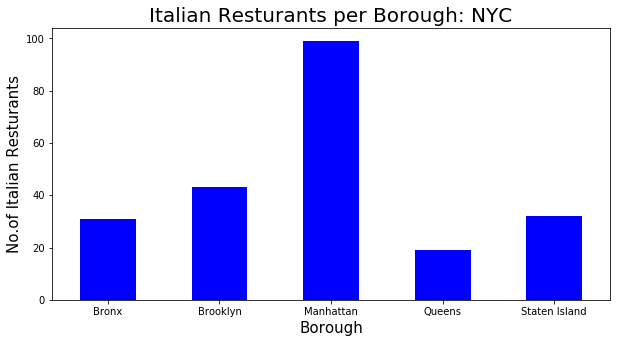

In [12]:
italian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = "blue")
plt.title('Italian Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Italian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

Judging from the graph above we can see that the borough of Manhattan has the highest number of Italian Restaurants followed by Brooklyn, Staten Island, then the Bronx. Whereas Queens has the least number of Italian Restaurants. This allows us to assume that Queens would be an ideal borough to open an Italian Restaurant in as the supply(number) is relatively low by comparison. 

In [13]:
italian_rest_ny[italian_rest_ny["Borough"] =="Queens"]

,Unnamed: 0,Borough,Neighborhood,ID,Name
149,149,Queens,Howard Beach,4bafdb5df964a52086263ce3,Prima Pasta & Cafe
150,150,Queens,Howard Beach,4bae3bd0f964a52009963be3,Brothers Ravioli
151,151,Queens,Howard Beach,4ba148f5f964a5201da937e3,Roma View Catering
152,152,Queens,Corona,4b808501f964a5207b7930e3,Park Side
153,153,Queens,Long Island City,57a13096498e42182b7df641,Oro Restaurant and Lounge
154,154,Queens,Maspeth,5c6183b006fb60002ca6572b,Patrizia's of Maspeth
155,155,Queens,Ridgewood,4b89b361f964a520074c32e3,Joe's Restaurant
156,156,Queens,Rego Park,4c50f9ae9d642d7f357fc6dc,Avellino Ristorante & Pizzeria
157,157,Queens,Bayside,4bb7ca5b1261d13a83e2e798,Papazzio Restaurant
158,158,Queens,Bayside,4d4e0113869cf04dd10ce4ae,Trattoria Thirty Five


In [14]:
italian_rest_queens=italian_rest_ny[italian_rest_ny["Borough"] =="Queens"]
italian_rest_queens

,Unnamed: 0,Borough,Neighborhood,ID,Name
149,149,Queens,Howard Beach,4bafdb5df964a52086263ce3,Prima Pasta & Cafe
150,150,Queens,Howard Beach,4bae3bd0f964a52009963be3,Brothers Ravioli
151,151,Queens,Howard Beach,4ba148f5f964a5201da937e3,Roma View Catering
152,152,Queens,Corona,4b808501f964a5207b7930e3,Park Side
153,153,Queens,Long Island City,57a13096498e42182b7df641,Oro Restaurant and Lounge
154,154,Queens,Maspeth,5c6183b006fb60002ca6572b,Patrizia's of Maspeth
155,155,Queens,Ridgewood,4b89b361f964a520074c32e3,Joe's Restaurant
156,156,Queens,Rego Park,4c50f9ae9d642d7f357fc6dc,Avellino Ristorante & Pizzeria
157,157,Queens,Bayside,4bb7ca5b1261d13a83e2e798,Papazzio Restaurant
158,158,Queens,Bayside,4d4e0113869cf04dd10ce4ae,Trattoria Thirty Five


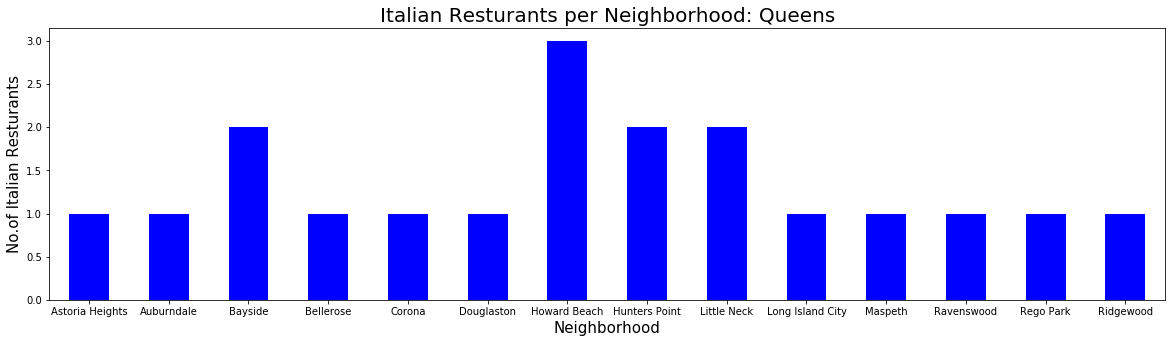

In [15]:
italian_rest_queens.groupby('Neighborhood')['ID'].count().plot.bar(figsize=(20,5), color = "blue")
plt.title('Italian Resturants per Neighborhood: Queens', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No.of Italian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

Looking at the graph above we can see that it wouldn't be in our best interest to open an Italian Restaurant in the neighborhoods of Howard Beach, Hunters Point, Little Neck, Bayside, or Corona as there is too much competition. It would behoove us to open in any of the remaining neighborhoods.

In [16]:
ny_neighborhoods = pd.merge(italian_rest_ny,ny_data, on = "Neighborhood")
ny_neighborhoods


,Unnamed: 0,Borough_x,Neighborhood,ID,Name,Borough_y,Latitude,Longitude
0,0,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn,Bronx,40.898273,-73.867315
1,1,Bronx,Pelham Parkway,4bf96ae65317a593d837017f,Enzo's,Bronx,40.857413,-73.854756
2,2,Bronx,Pelham Parkway,4b47f069f964a5208c4426e3,Pasta Pasta,Bronx,40.857413,-73.854756
3,3,Bronx,City Island,4514ed4df964a520e5391fe3,Artie's Steak and Seafood,Bronx,40.847247,-73.786488
4,4,Bronx,Country Club,4be35e62b02ec9b6b66b4fc0,Vibano's,Bronx,40.844246,-73.824099
5,5,Bronx,Morris Park,4b10591af964a5205f6e23e3,Patricia's,Bronx,40.847549,-73.850402
6,6,Bronx,Belmont,4acf80aef964a52025d420e3,Tino's Delicatessen,Bronx,40.857277,-73.888452
7,7,Bronx,Belmont,4af71916f964a520cf0522e3,Michaelangelo's Coal Fired Brick Oven Pizza Re...,Bronx,40.857277,-73.888452
8,8,Bronx,Belmont,59050f51b23dfa5f6649e678,Arthur Avenue Fiasco,Bronx,40.857277,-73.888452
9,9,Bronx,Belmont,4bb6470cef159c7465b275f7,Calabria Pork Store,Bronx,40.857277,-73.888452


In [17]:
ny_map = folium.Map(location = geo_location("New York"),zoom_start = 12)
ny_geo = r"Borough Boundaries.geojson"

In [18]:
ny_neighborhoods['Label']=ny_neighborhoods['Neighborhood']+','+ny_neighborhoods['Borough_y']+"," +ny_neighborhoods['Borough_x'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhoods[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map

The above map shows a the dispersion of the italian restaurants in the Boroughs of NYC.

## Conclusion & Results

By our analysis it is apparent that the borough of Queens has the least number of Italian Restaurants in comparison to the rest of the boroughs. In order to maximize our chances of success, we would have to open a restaurant in the one of the neighborhoods in Queens that has the least number of Italian restaurants. Whereas if we wanted more competition and to decrease the chance of succeeding we would open a restaurant in Manhattan. There is a small caveat with the above data though. All of this data is entirely dependent of the accuracy of Four Square's data. In order to gain better insight and perform a more comprehensive analysis we would utilize data from other databases. 